# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [2]:
# Change here using YOUR first and last names
fn1 = "Julian"
ln1 = "FIDELIN--DURAND"
fn2 = "Simon"
ln2 = "ZARKA-ARTHUS"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_fidelin--durand_julian_and_zarka-arthus_simon.ipynb


In [3]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

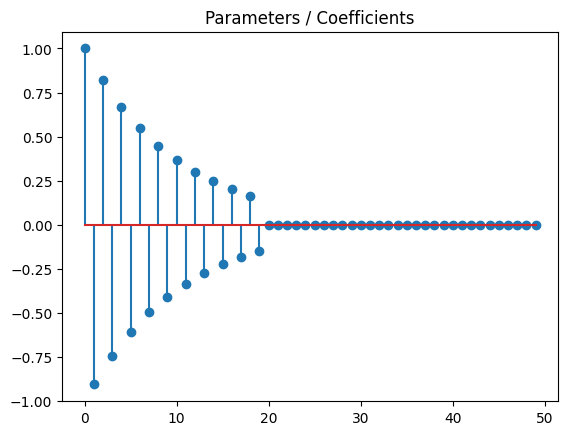

In [5]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [6]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

C:\Users\simon\AppData\Local\Temp\ipykernel_14816\1662604985.py:2: DeprecationWarning: Please import `toeplitz` from the `scipy.linalg` namespace; the `scipy.linalg.special_matrices` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.linalg.special_matrices import toeplitz


## Generate the data

In [7]:
A, b = simu_linreg(coefs)
A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [16]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""    
    return np.sign(x) * ((abs(x) - lmbd) > 0) * (abs(x) - lmbd)# TODO
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.linalg.norm(x, 1)   # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    return x / (1 + lmbd) # TODO
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * np.linalg.norm(x, 2) / 2 # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

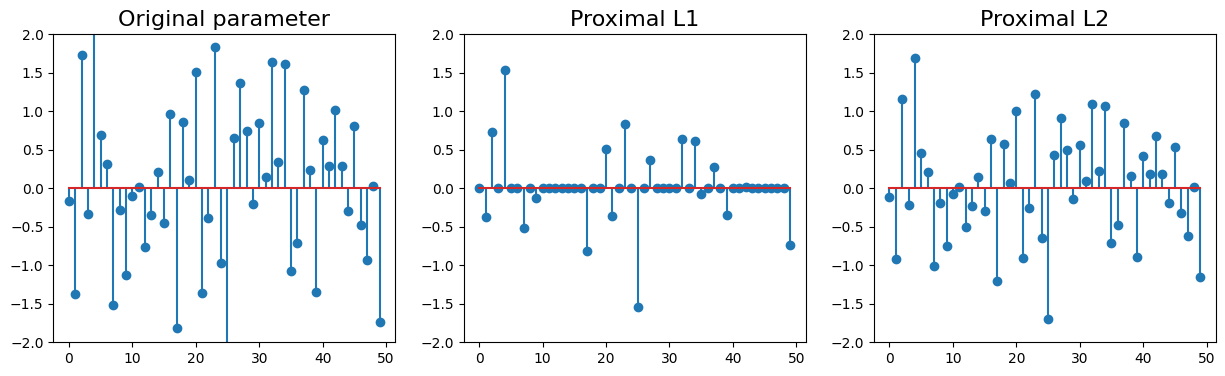

In [9]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

It can be seen that the proximal L1 set parameters closer to zero on average even thought both reduce them. Proximal L2 is less categorical. 

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [10]:
def loss_linreg(x):
    """Least-squares loss"""
    return np.linalg.norm(b - A @ x)**2 / (2 * A.shape[0])

def grad_linreg(x):
    """Least-squares gradient"""
    return - A.T @ (b - A @ x) / A.shape[0]

def loss_logreg(x):
    """Logistic loss"""
    return np.sum(np.log(1 + np.exp(-b * (A @ x)))) / A.shape[0]

def grad_logreg(x):
    """Logistic gradient"""
    n = A.shape[0]  # number of samples
    predictions = A @ x
    sigma_values = 1 / (1 + np.exp(-b * predictions))
    return (-1 / n) * A.T @ (b * (1 - sigma_values))

# TO BE COMPLETED

In [11]:
from scipy.optimize import check_grad
check_grad(loss_linreg, grad_linreg, A[0])

7.257422606541633e-06

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [12]:
# TO BE COMPLETED

# Calculate the smoothness constant for L2
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    return np.linalg.norm(A, 2) ** 2
# Calculate the smoothness constant for Logistic loss   
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    return np.linalg.norm(A, 2) ** 2 / 4

    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new -= grad_f(x) 
        x = prox_R(x + step * x_new, lmbd)
        
        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [20]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_R(z - step * grad_f(z), lmbd)
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        z = x_new + (t - 1) / (t_new) * (x_new - x)
        x = x_new.copy()
        t = t_new

        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [14]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
step = 1 / np.linalg.norm(A, 2) ** 2
n_iter = 1000
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 5.00e-01 | 1.00e+00
      10 | 4.97e-01 | 9.97e-01
      20 | 4.90e-01 | 9.91e-01
      30 | 4.80e-01 | 9.82e-01
      40 | 4.69e-01 | 9.71e-01
      50 | 4.57e-01 | 9.57e-01
      60 | 4.45e-01 | 9.41e-01
      70 | 4.33e-01 | 9.24e-01
      80 | 4.22e-01 | 9.06e-01
      90 | 4.12e-01 | 8.87e-01
     100 | 4.02e-01 | 8.67e-01
     110 | 3.94e-01 | 8.47e-01
     120 | 3.86e-01 | 8.27e-01
     130 | 3.78e-01 | 8.07e-01
     140 | 3.72e-01 | 7.88e-01
     150 | 3.67e-01 | 7.69e-01
     160 | 3.62e-01 | 7.51e-01
     170 | 3.58e-01 | 7.33e-01
     180 | 3.56e-01 | 7.16e-01
     190 | 3.53e-01 | 7.00e-01
     200 | 3.52e-01 | 6.85e-01
     210 | 3.50e-01 | 6.71e-01
     220 | 3.49e-01 | 6.58e-01
     230 | 3.48e-01 | 6.46e-01
     240 | 3.48e-01 | 6.35e-01
     250 | 3.47e-01 | 6.25e-01
     260 | 3.47e-01 | 6.16e-01
     270 | 3.47e-01 | 6.08e-01
     280 | 3.47e-01 | 6.01e-01
     290 | 3.47e-01 | 5.95e-01
     300 | 3.47e-

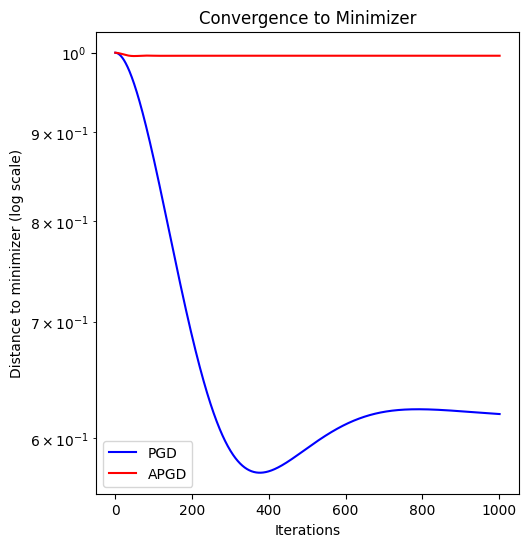

In [21]:
x_pgd, objectives_pgd, errors_pgd = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step, lmbd, n_iter, coefs)
x_apgd, objectives_apgd, errors_apgd = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step, lmbd, n_iter, coefs)


# Tracé des courbes de convergence
plt.figure(figsize=(12, 6))

# Distance au minimiseur
plt.subplot(1, 2, 1)
plt.plot(errors_pgd, label='PGD', color='blue')
plt.plot(errors_apgd, label='APGD', color='red')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Distance to minimizer (log scale)')
plt.title('Convergence to Minimizer')
plt.legend()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 5.00e-01 | 1.00e+00
      10 | 4.97e-01 | 9.97e-01
      20 | 4.90e-01 | 9.91e-01
      30 | 4.80e-01 | 9.82e-01
      40 | 4.69e-01 | 9.71e-01
      50 | 4.57e-01 | 9.57e-01
      60 | 4.45e-01 | 9.41e-01
      70 | 4.33e-01 | 9.24e-01
      80 | 4.22e-01 | 9.06e-01
      90 | 4.12e-01 | 8.87e-01
     100 | 4.02e-01 | 8.67e-01
     110 | 3.94e-01 | 8.47e-01
     120 | 3.86e-01 | 8.27e-01
     130 | 3.78e-01 | 8.07e-01
     140 | 3.72e-01 | 7.88e-01
     150 | 3.67e-01 | 7.69e-01
     160 | 3.62e-01 | 7.51e-01
     170 | 3.58e-01 | 7.33e-01
     180 | 3.56e-01 | 7.16e-01
     190 | 3.53e-01 | 7.00e-01
     200 | 3.52e-01 | 6.85e-01
     210 | 3.50e-01 | 6.71e-01
     220 | 3.49e-01 | 6.58e-01
     230 | 3.48e-01 | 6.46e-01
     240 | 3.48e-01 | 6.35e-01
     250 | 3.47e-01 | 6.25e-01
     260 | 3.47e-01 | 6.16e-01
     270 | 3.47e-01 | 6.08e-01
     280 | 3.47e-01 | 6.01e-01
     290 | 3.47e-01 | 5.95e-01
     300 | 3.47e-

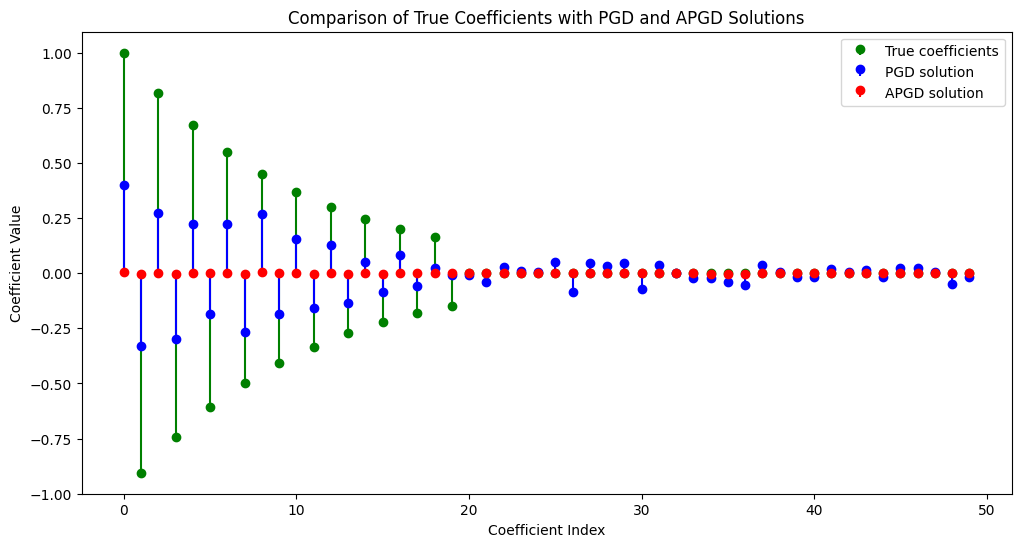

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 1.00e+00
      10 | 6.93e-01 | 1.00e+00
      20 | 6.93e-01 | 1.00e+00
      30 | 6.93e-01 | 1.00e+00
      40 | 6.93e-01 | 1.00e+00
      50 | 6.93e-01 | 1.00e+00
      60 | 6.93e-01 | 1.00e+00
      70 | 6.93e-01 | 1.00e+00
      80 | 6.93e-01 | 1.00e+00
      90 | 6.93e-01 | 1.00e+00
     100 | 6.93e-01 | 1.00e+00
     110 | 6.92e-01 | 9.98e-01
     120 | 6.89e-01 | 9.95e-01
     130 | 6.85e-01 | 9.90e-01
     140 | 6.80e-01 | 9.83e-01
     150 | 6.74e-01 | 9.74e-01
     160 | 6.67e-01 | 9.62e-01
     170 | 6.58e-01 | 9.47e-01
     180 | 6.49e-01 | 9.29e-01
     190 | 6.38e-01 | 9.09e-01
     200 | 6.28e-01 | 8.85e-01
     210 | 6.17e-01 | 8.59e-01
     220 | 6.07e-01 | 8.31e-01
     230 | 5.97e-01 | 8.02e-01
     240 | 5.88e-01 | 7.70e-01
     250 | 5.80e-01 | 7.37e-01
     260 | 5.73e-01 | 7.04e-01
     270 | 5.66e-01 | 6.72e-01
     280 | 5.61e-01 | 6.40e-01
     290 | 5.57e-01 | 6.10e-01
     300 | 5.54e-

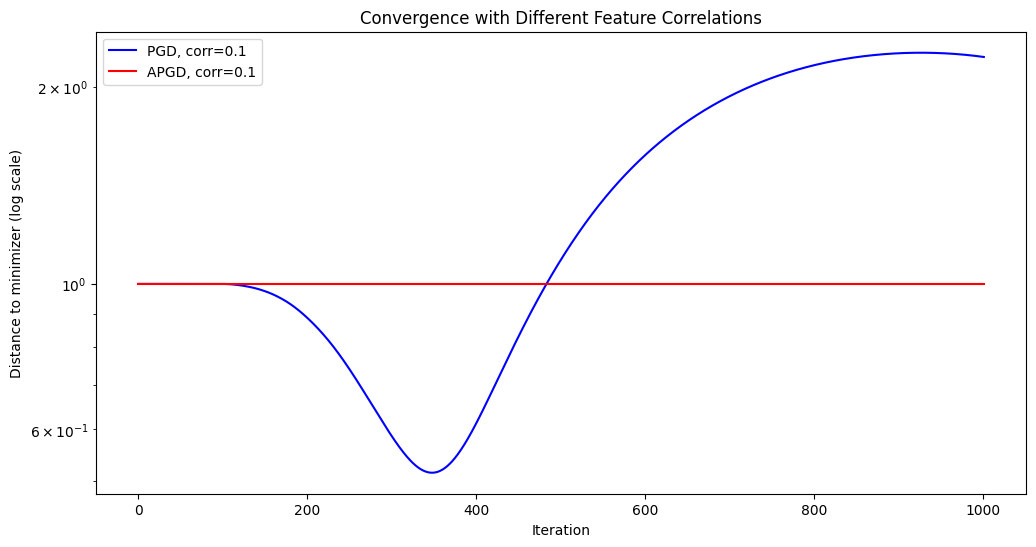

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 1.00e+00
      10 | 6.93e-01 | 1.00e+00
      20 | 6.93e-01 | 1.00e+00
      30 | 6.93e-01 | 1.00e+00
      40 | 6.93e-01 | 1.00e+00
      50 | 6.93e-01 | 1.00e+00
      60 | 6.93e-01 | 1.00e+00
      70 | 6.93e-01 | 1.00e+00
      80 | 6.93e-01 | 1.00e+00
      90 | 6.93e-01 | 1.00e+00
     100 | 6.93e-01 | 1.00e+00
     110 | 6.93e-01 | 1.00e+00
     120 | 6.93e-01 | 1.00e+00
     130 | 6.93e-01 | 1.00e+00
     140 | 6.93e-01 | 1.00e+00
     150 | 6.93e-01 | 1.00e+00
     160 | 6.93e-01 | 1.00e+00
     170 | 6.93e-01 | 1.00e+00
     180 | 6.93e-01 | 1.00e+00
     190 | 6.93e-01 | 1.00e+00
     200 | 6.93e-01 | 1.00e+00
     210 | 6.93e-01 | 1.00e+00
     220 | 6.93e-01 | 1.00e+00
     230 | 6.92e-01 | 9.99e-01
     240 | 6.91e-01 | 9.97e-01
     250 | 6.89e-01 | 9.94e-01
     260 | 6.87e-01 | 9.91e-01
     270 | 6.84e-01 | 9.87e-01
     280 | 6.81e-01 | 9.82e-01
     290 | 6.77e-01 | 9.77e-01
     300 | 6.74e-

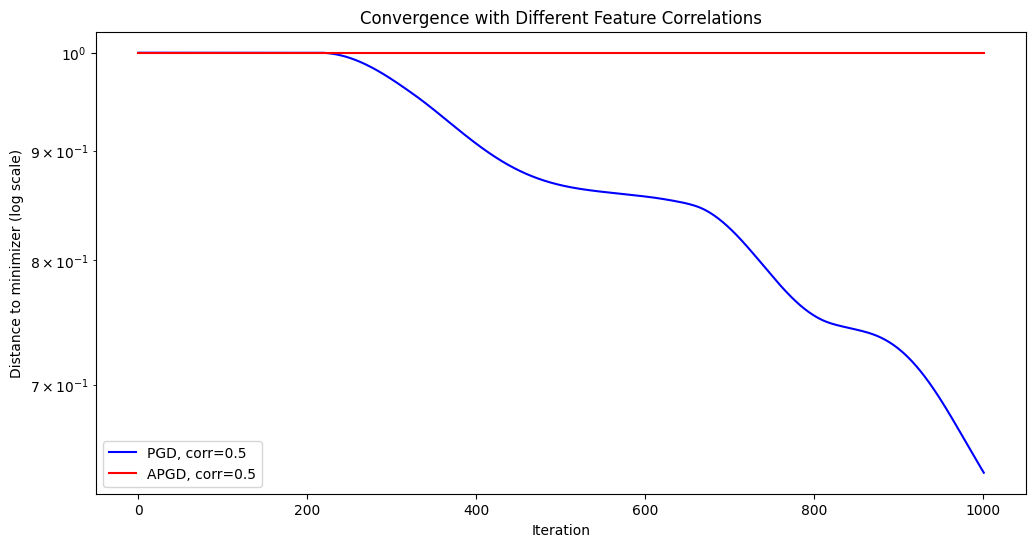

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 1.00e+00
      10 | 6.93e-01 | 1.00e+00
      20 | 6.93e-01 | 1.00e+00
      30 | 6.93e-01 | 1.00e+00
      40 | 6.93e-01 | 1.00e+00
      50 | 6.93e-01 | 1.00e+00
      60 | 6.93e-01 | 1.00e+00
      70 | 6.93e-01 | 1.00e+00
      80 | 6.93e-01 | 1.00e+00
      90 | 6.93e-01 | 1.00e+00
     100 | 6.93e-01 | 1.00e+00
     110 | 6.93e-01 | 1.00e+00
     120 | 6.93e-01 | 1.00e+00
     130 | 6.93e-01 | 1.00e+00
     140 | 6.93e-01 | 1.00e+00
     150 | 6.93e-01 | 1.00e+00
     160 | 6.93e-01 | 1.00e+00
     170 | 6.93e-01 | 1.00e+00
     180 | 6.93e-01 | 1.00e+00
     190 | 6.93e-01 | 1.00e+00
     200 | 6.93e-01 | 1.00e+00
     210 | 6.93e-01 | 1.00e+00
     220 | 6.93e-01 | 1.00e+00
     230 | 6.93e-01 | 1.00e+00
     240 | 6.93e-01 | 1.00e+00
     250 | 6.93e-01 | 1.00e+00
     260 | 6.93e-01 | 1.00e+00
     270 | 6.93e-01 | 1.00e+00
     280 | 6.93e-01 | 1.00e+00
     290 | 6.93e-01 | 1.00e+00
     300 | 6.93e-

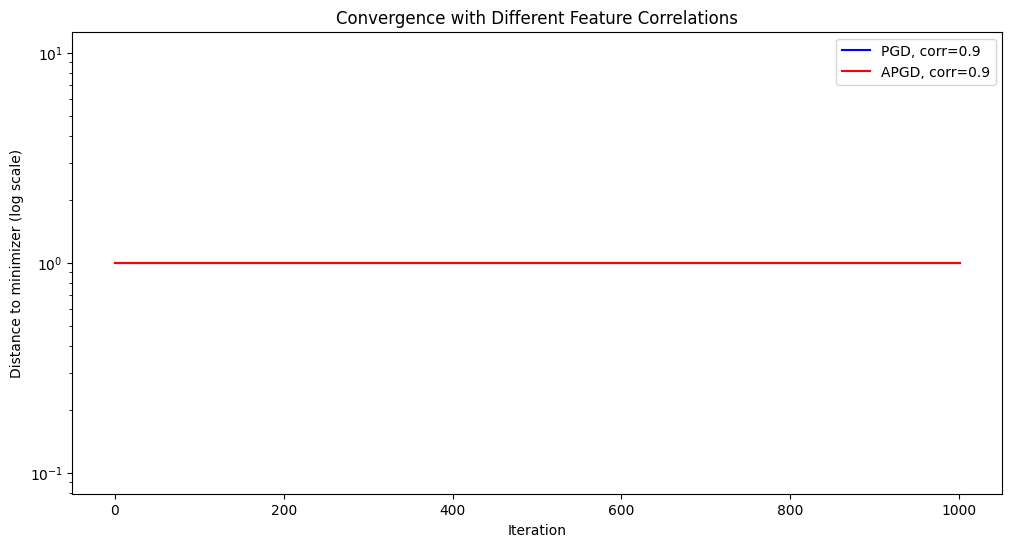

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 5.00e-01 | 1.00e+00
      10 | 4.99e-01 | 1.00e+00
      20 | 4.96e-01 | 9.99e-01
      30 | 4.92e-01 | 9.99e-01
      40 | 4.88e-01 | 9.98e-01
      50 | 4.85e-01 | 9.97e-01
      60 | 4.82e-01 | 9.96e-01
      70 | 4.80e-01 | 9.95e-01
      80 | 4.78e-01 | 9.94e-01
      90 | 4.78e-01 | 9.92e-01
     100 | 4.77e-01 | 9.91e-01
     110 | 4.76e-01 | 9.90e-01
     120 | 4.75e-01 | 9.89e-01
     130 | 4.74e-01 | 9.87e-01
     140 | 4.72e-01 | 9.86e-01
     150 | 4.71e-01 | 9.84e-01
     160 | 4.69e-01 | 9.83e-01
     170 | 4.68e-01 | 9.82e-01
     180 | 4.67e-01 | 9.80e-01
     190 | 4.66e-01 | 9.79e-01
     200 | 4.65e-01 | 9.78e-01
     210 | 4.65e-01 | 9.76e-01
     220 | 4.64e-01 | 9.75e-01
     230 | 4.64e-01 | 9.73e-01
     240 | 4.63e-01 | 9.72e-01
     250 | 4.63e-01 | 9.71e-01
     260 | 4.62e-01 | 9.69e-01
     270 | 4.61e-01 | 9.68e-01
     280 | 4.61e-01 | 9.66e-01
     290 | 4.60e-01 | 9.65e-01
     300 | 4.60e-

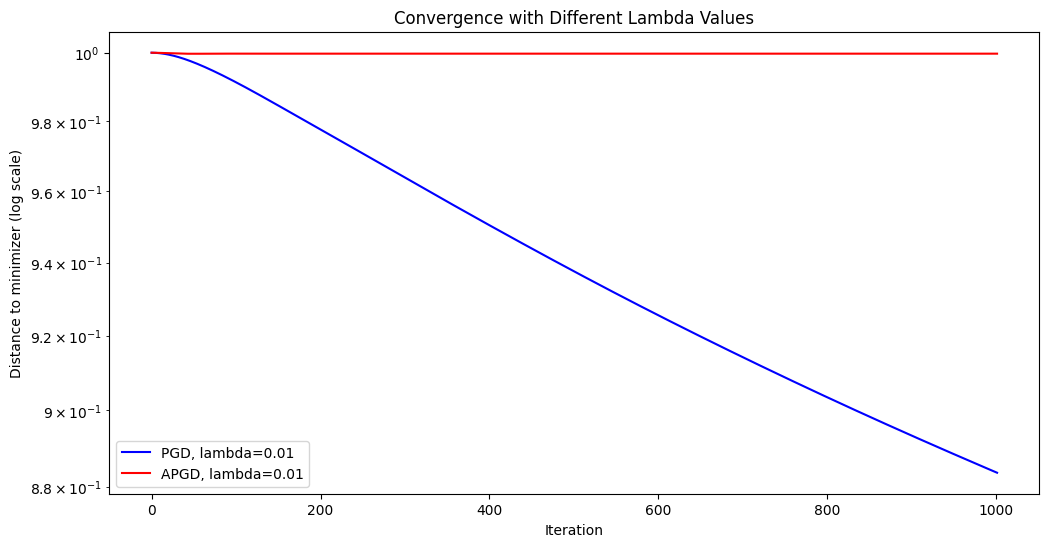

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 5.00e-01 | 1.00e+00
      10 | 4.99e-01 | 1.00e+00
      20 | 4.98e-01 | 1.00e+00
      30 | 4.96e-01 | 9.99e-01
      40 | 4.95e-01 | 9.99e-01
      50 | 4.93e-01 | 9.99e-01
      60 | 4.92e-01 | 9.99e-01
      70 | 4.91e-01 | 9.98e-01
      80 | 4.90e-01 | 9.98e-01
      90 | 4.89e-01 | 9.98e-01
     100 | 4.88e-01 | 9.98e-01
     110 | 4.88e-01 | 9.97e-01
     120 | 4.87e-01 | 9.97e-01
     130 | 4.86e-01 | 9.97e-01
     140 | 4.86e-01 | 9.97e-01
     150 | 4.85e-01 | 9.96e-01
     160 | 4.85e-01 | 9.96e-01
     170 | 4.84e-01 | 9.96e-01
     180 | 4.84e-01 | 9.96e-01
     190 | 4.84e-01 | 9.96e-01
     200 | 4.83e-01 | 9.95e-01
     210 | 4.83e-01 | 9.95e-01
     220 | 4.83e-01 | 9.95e-01
     230 | 4.82e-01 | 9.95e-01
     240 | 4.82e-01 | 9.94e-01
     250 | 4.82e-01 | 9.94e-01
     260 | 4.81e-01 | 9.94e-01
     270 | 4.81e-01 | 9.94e-01
     280 | 4.81e-01 | 9.94e-01
     290 | 4.81e-01 | 9.93e-01
     300 | 4.80e-

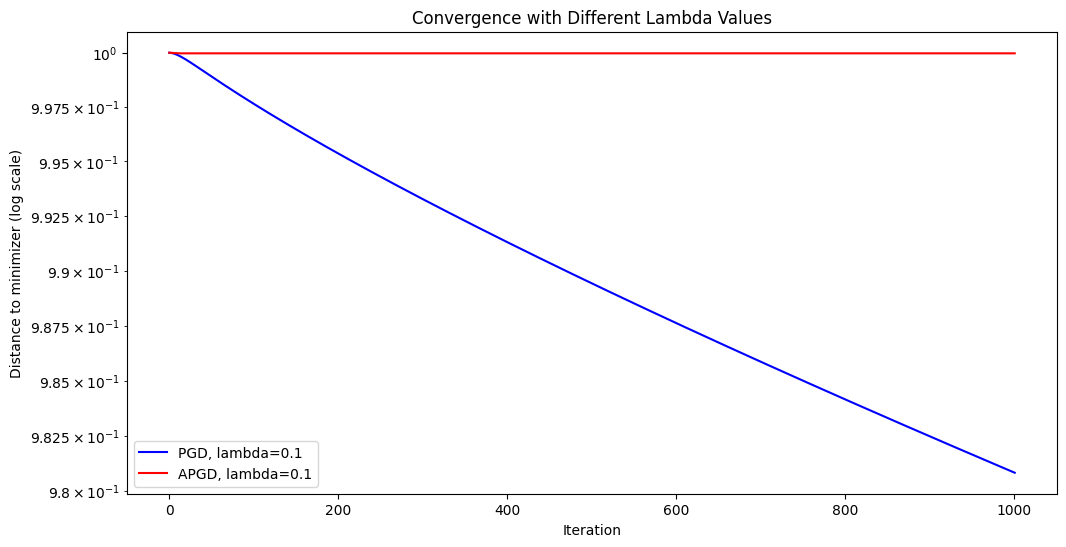

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 5.00e-01 | 1.00e+00
      10 | 5.00e-01 | 1.00e+00
      20 | 5.00e-01 | 1.00e+00
      30 | 5.00e-01 | 1.00e+00
      40 | 5.00e-01 | 1.00e+00
      50 | 5.00e-01 | 1.00e+00
      60 | 5.00e-01 | 1.00e+00
      70 | 5.00e-01 | 1.00e+00
      80 | 5.00e-01 | 1.00e+00
      90 | 5.00e-01 | 1.00e+00
     100 | 5.00e-01 | 1.00e+00
     110 | 5.00e-01 | 1.00e+00
     120 | 5.00e-01 | 1.00e+00
     130 | 5.00e-01 | 1.00e+00
     140 | 5.00e-01 | 1.00e+00
     150 | 5.00e-01 | 1.00e+00
     160 | 5.00e-01 | 1.00e+00
     170 | 5.00e-01 | 1.00e+00
     180 | 5.00e-01 | 1.00e+00
     190 | 5.00e-01 | 9.99e-01
     200 | 5.00e-01 | 9.99e-01
     210 | 5.00e-01 | 9.99e-01
     220 | 5.00e-01 | 9.99e-01
     230 | 5.00e-01 | 9.99e-01
     240 | 5.00e-01 | 9.99e-01
     250 | 5.00e-01 | 9.99e-01
     260 | 5.00e-01 | 9.99e-01
     270 | 5.00e-01 | 9.99e-01
     280 | 5.00e-01 | 9.99e-01
     290 | 5.00e-01 | 9.99e-01
     300 | 5.00e-

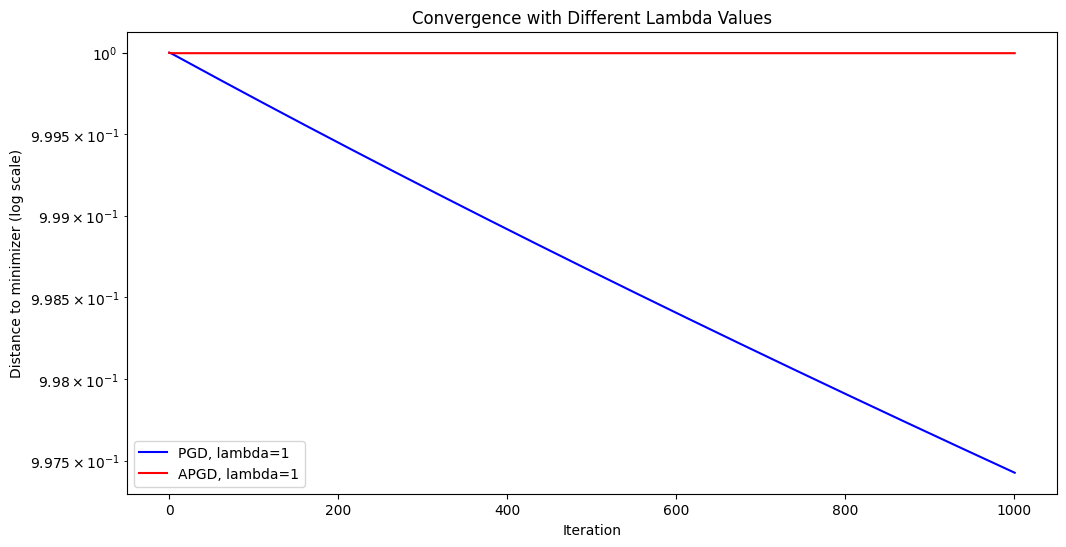

In [22]:

# Question 1: Comparaison des solutions obtenues avec PGD et APGD

# Calculer les solutions avec PGD et APGD pour la régression linéaire avec régularisation L2
x_pgd, _, _ = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step, lmbd, n_iter, coefs)
x_apgd, _, _ = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step, lmbd, n_iter, coefs)

# Tracer les coefficients pour comparer PGD, APGD et les vrais coefficients
plt.figure(figsize=(12, 6))
plt.stem(coefs, markerfmt='go', label='True coefficients', linefmt='g-', basefmt=" ")
plt.stem(x_pgd, markerfmt='bo', label='PGD solution', linefmt='b-', basefmt=" ")
plt.stem(x_apgd, markerfmt='ro', label='APGD solution', linefmt='r-', basefmt=" ")
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title('Comparison of True Coefficients with PGD and APGD Solutions')
plt.legend()
plt.show()

# Question 2: Influence de la corrélation des caractéristiques sur les performances des algorithmes

correlation_values = [0.1, 0.5, 0.9]
for corr in correlation_values:
    A, b = simu_logreg(coefs, n_samples=1000, corr=corr)
    step = 1 / np.linalg.norm(A, 2) ** 2
    
    x_pgd, _, errors_pgd = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step, lmbd, n_iter, coefs)
    x_apgd, _, errors_apgd = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, step, lmbd, n_iter, coefs)
    
    plt.figure(figsize=(12, 6))
    plt.semilogy(errors_pgd, label=f'PGD, corr={corr}', color='b')
    plt.semilogy(errors_apgd, label=f'APGD, corr={corr}', color='r')
    plt.xlabel('Iteration')
    plt.ylabel('Distance to minimizer (log scale)')
    plt.title('Convergence with Different Feature Correlations')
    plt.legend()
    plt.show()

# Question 3: Influence du niveau de pénalisation (lambda) sur les performances des algorithmes

lambda_values = [0.01, 0.1, 1]
for lmbd in lambda_values:
    x_pgd, _, errors_pgd = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step, lmbd, n_iter, coefs)
    x_apgd, _, errors_apgd = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step, lmbd, n_iter, coefs)
    
    plt.figure(figsize=(12, 6))
    plt.semilogy(errors_pgd, label=f'PGD, lambda={lmbd}', color='b')
    plt.semilogy(errors_apgd, label=f'APGD, lambda={lmbd}', color='r')
    plt.xlabel('Iteration')
    plt.ylabel('Distance to minimizer (log scale)')
    plt.title('Convergence with Different Lambda Values')
    plt.legend()
    plt.show()

Comparaison des solutions obtenues avec PGD et APGD avec le vrai paramètre coefs :

Dans les tracés obtenus, on voit les valeurs des coefficients estimés par les deux algorithmes (PGD et APGD) et on les compare aux vrais coefficients (coefs). Si les deux algorithmes sont performants, les points bleus (PGD) et rouges (APGD) se trouvent proches des points verts (les vrais coefficients).
APGD converge plus rapidement vers la solution optimale grâce à son accélération. 

Influence de la corrélation des caractéristiques sur les performances des algorithmes :

Quand on fait varier la corrélation entre les caractéristiques, on remarque que la convergence de PGD et d'APGD ralentit à mesure que la corrélation augmente. Les erreurs des deux algorithmes diminuent plus lentement pour des valeurs de corrélation élevées.
Une forte corrélation entre les caractéristiques rend le problème d'optimisation plus difficile à résoudre car les directions de descente sont moins distinctes. Cela entraîne une convergence plus lente pour les algorithmes de descente de gradient.

Influence du niveau de pénalisation (lambda) sur les performances des algorithmes :

En augmentant la valeur de lambda, on constate que la convergence de PGD et d'APGD est affectée différemment. Pour des valeurs élevées de lambda, les coefficients estimés sont plus proches de zéro, ce qui reflète un plus fort degré de régularisation.
Lorsque lambda augmente, la régularisation L1 ou L2 devient plus stricte, forçant les coefficients à se réduire pour éviter un sur-ajustement. Cela se traduit par des solutions plus biaisées mais avec une variance réduite. APGD bénéficie de son accélération pour converger plus rapidement, surtout lorsque la valeur de lambda est modérée.